In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [3]:
from Preprocessor import Preprocessor
from Registerer import Registerer
import SimpleITK as sitk
import ndreg

### Step 1: Load data

In [4]:
img = ndreg.imgRead('../forVikram/ailey-dev_thy1eyfp_control_9_upload20170919_ch1_res3.img')
atlas = ndreg.imgRead('../forVikram/ara3_average_res2.img')

### Step 2: initialize Preprocessor class

In [5]:
preprocessor = Preprocessor(img)

### Step 3: remove streaks

In [6]:
new_img = preprocessor.remove_streaks()

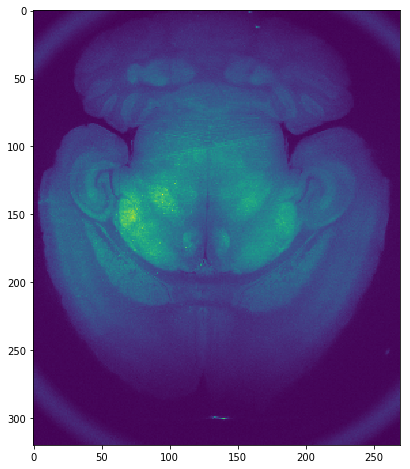

In [7]:
plt.imshow(preprocessor.img_np[80,:,:])
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


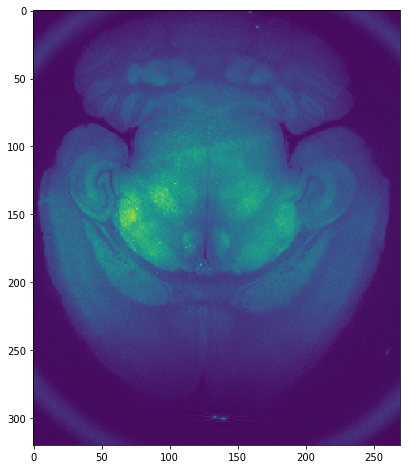

In [8]:
plt.imshow(new_img[80,:,:].astype('float'))
plt.show()

### Step 4: Remove circle

In [9]:
img_no_circle = preprocessor.remove_circle()

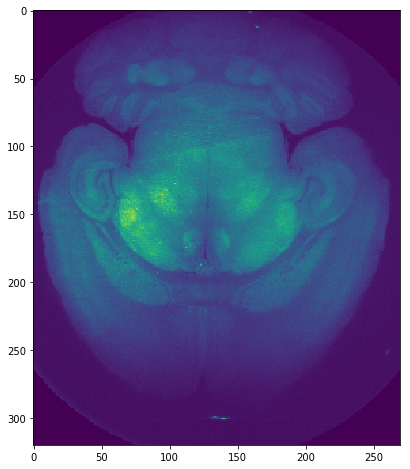

In [10]:
plt.imshow(img_no_circle[80,:,:])
plt.show()

### Step 5: create mask

In [11]:
mask = preprocessor.create_mask()

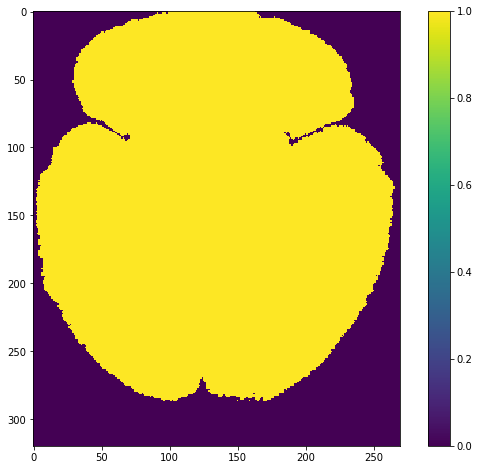

In [12]:
plt.imshow(mask[80,:,:])
plt.colorbar()
plt.show()

### Step 6: Correct Bias field

In [13]:
img_bias_corrected = preprocessor.correct_bias_field(mask=mask, scale=0.1)

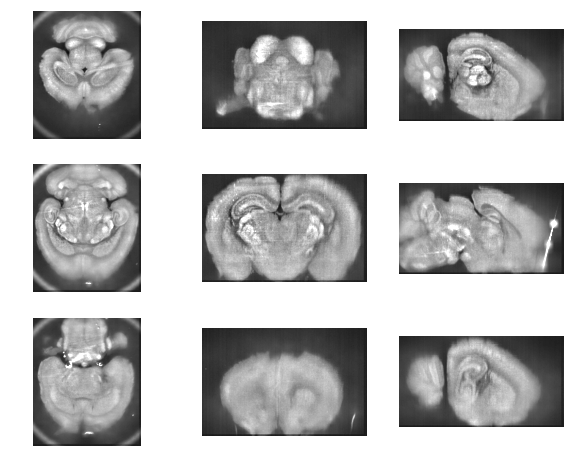

In [14]:
ndreg.imgShow(img_bias_corrected, vmax=1000)

## Registration

In [15]:
registerer = Registerer(img, atlas, "RPS", "LSA")

### Perform affine registration

In [16]:
atlas_affine = registerer.register_affine([0.100, 0.100, 0.100], iterations=1000.0, resolutions=4.0)

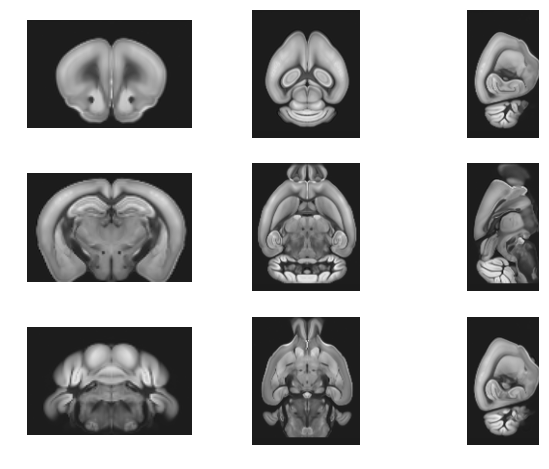

In [17]:
ndreg.imgShow(atlas_affine)

### Perform LDDMM registration

In [18]:
atlas_lddmm = registerer.register_lddmm(scaleList=[0.0625], epsilonList=5e-4)


Step 0: alpha=0.05, beta=0.05, scale=0.0625
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	26.0966, 4.931e-07, 0, 26.0966 (99.9934%), 5.500000e-04
1.	26.0947, 2.17269e-06, 0, 26.0947 (99.9862%), 6.050000e-04
2.	26.0926, 5.39263e-06, 0, 26.0926 (99.9782%), 6.655000e-04
3.	26.0904, 1.05904e-05, 0, 26.0903 (99.9695%), 7.320500e-04
4.	26.0879, 1.83052e-05, 0, 26.0878 (99.9599%), 8.052550e-04
5.	26.0851, 2.91997e-05, 0, 26.0851 (99.9493%), 8.857805e-04
6.	26.0821, 4.40865e-05, 0, 26.0821 (99.9378%), 9.743586e-04
7.	26.0788, 6.39597e-05, 0, 26.0788 (99.9251%), 1.071794e-03
8.	26.0752, 9.00329e-05, 0, 26.0751 (99.9111%), 1.178974e-03
9.	26.0713, 0.000123785, 0, 26.0711 (99.8959%), 1.296871e-03
10.	26.0669, 0.000167014, 0, 26.0668 (99.8791%), 1.426558e-03
11.	26.0622, 0.000221904, 0, 26.062 (99.8607%), 1.569214e-03
12.	26.057, 0.000291102, 0, 26.0567 (99.8406%), 1.726136e-03
13.	26.0513, 0.000377812, 0, 26.0509 (99.8185%), 1.898749e-03
14.	26.0451, 0.000485903, 0, 26.0446 (99.79

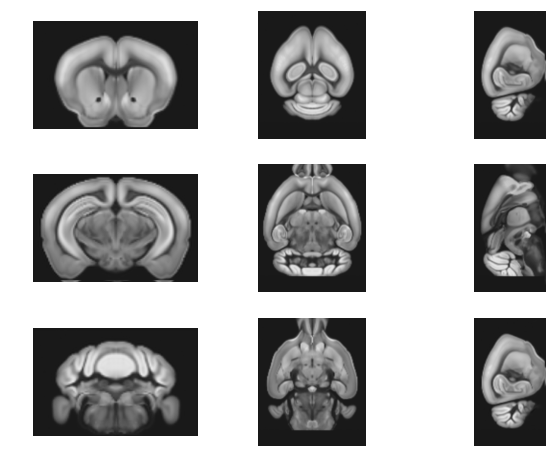

In [20]:
ndreg.imgShow(atlas_lddmm)